In [1]:
import sys
from utils.best_split_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
df_motif = pd.read_csv("./motif_dataset.csv")
df_motif.set_index("md5", inplace=True)
df_motif.head(), df_motif.shape

(                                          family first_submission_date
 md5                                                                   
 001d216ee755f0bc96125892e2fb3e3a         shamoon               2018-12
 006b418307c534754f055436a91848aa       downdelph               2016-10
 00b35fb5c534dea3ea13c8be4e4585cc  discordiaminer               2017-05
 00c417425a73db5a315d23fac8cb353f         shamoon               2017-07
 00cd973ae62f7824dfce7bebda46dcf1          ramnit               2018-10,
 (1947, 2))

In [3]:
import os

base_motif_path = "/home/luca/feature_extraction/ember/MOTIF/MOTIF/MOTIF_defanged/"
motif_filenames = os.listdir(base_motif_path)
motif_filenames = [
    os.path.join(base_motif_path, s)
    for s in motif_filenames
    if s.removeprefix("MOTIF_") in df_motif.index
]
len(motif_filenames)

1947

In [4]:
import pefile


def is_truncated(path: str) -> bool:
    pe = pefile.PE(path, fast_load=True)
    max_section_offset = 0
    for section in pe.sections:
        file_offset = section.PointerToRawData
        size = min(section.SizeOfRawData, section.Misc_VirtualSize)
        max_section_offset = max(max_section_offset, file_offset + size)
    file_size = len(pe.__data__)
    pe.close()
    return file_size < max_section_offset

In [5]:
from multiprocessing import Pool

with Pool(32) as p:
    motif_truncated_info = p.map(is_truncated, motif_filenames)

In [6]:
truncated_df = pd.DataFrame(
    {
        "md5": [s.removeprefix(base_motif_path + "MOTIF_") for s in motif_filenames],
        "truncated": motif_truncated_info,
    }
)
# truncated_df = truncated_df[truncated_df["truncated"]]
truncated_df.set_index("md5", inplace=True)
truncated_df.head()

,truncated
md5,
cffeb77be6d9f39a6ece669be9626af9,False
bb992ba5a4b4a882a169a5583d26cb2b,False
6a9348f582b2e121a5d9bff1e8f0935f,False
acf5b11b92aa8c99a2807b62c68e3cc7,False
6fba25e5a99ec3a628d8cd2018600409,False


In [7]:
truncated_df["family"] = df_motif.loc[truncated_df.index, "family"]
truncated_df.head()

,truncated,family
md5,,
cffeb77be6d9f39a6ece669be9626af9,False,sage
bb992ba5a4b4a882a169a5583d26cb2b,False,sagerunex
6a9348f582b2e121a5d9bff1e8f0935f,False,treasurehunt
acf5b11b92aa8c99a2807b62c68e3cc7,False,redaman
6fba25e5a99ec3a628d8cd2018600409,False,cerber


<Figure size 640x480 with 0 Axes>

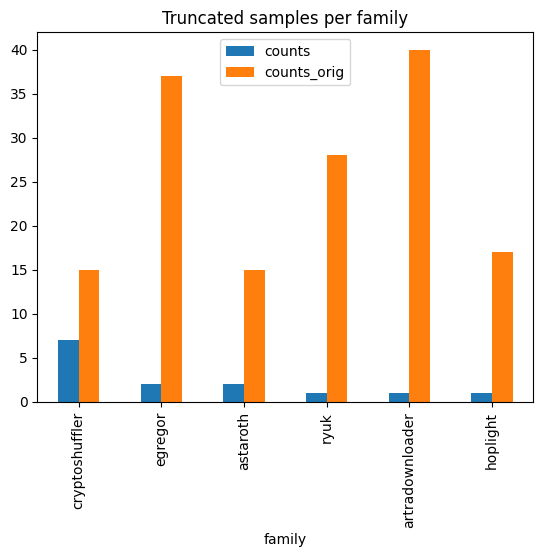

In [8]:
plt.figure()

truncated_df1 = truncated_df[truncated_df["truncated"]]

df = pd.DataFrame(
    {
        "counts": truncated_df1["family"].value_counts(),
        "family": truncated_df1["family"].value_counts().index,
    }
)
df.set_index("family", inplace=True)

value_counts = df_motif["family"][
    df_motif["family"].isin(truncated_df1["family"])
].value_counts()
df.loc[value_counts.index, "counts_orig"] = value_counts

df.plot(kind="bar", title="Truncated samples per family")
plt.show()

In [9]:
df.loc["cryptoshuffler"]

counts          7.0
counts_orig    15.0
Name: cryptoshuffler, dtype: float64

In [10]:
df = truncated_df.groupby("family").agg({"truncated": "sum"})

In [11]:
all_families = df_motif["family"].unique()
n_families_to_exclude = [
    len(list(df[df["truncated"] >= i].index)) / len(all_families) for i in range(101)
]

In [12]:
n_families_to_exclude_tozero = []
for p in n_families_to_exclude:
    if p == 0:
        n_families_to_exclude_tozero.append(0)
        break
    else:
        n_families_to_exclude_tozero.append(p)

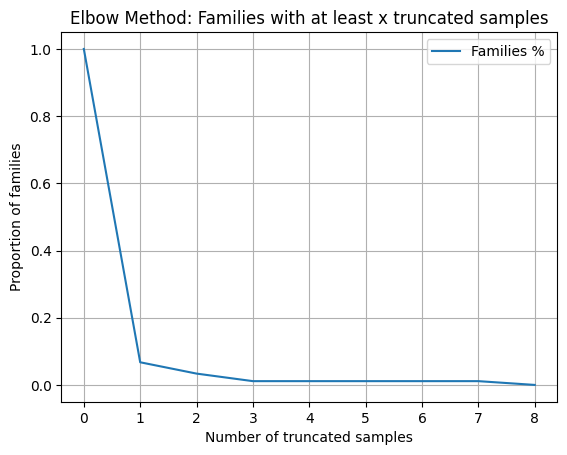

In [13]:
import seaborn as sns

plt.title("Elbow Method: Families with at least x truncated samples")
sns.lineplot(n_families_to_exclude_tozero, label="Families %")

plt.legend()
plt.grid()
plt.xlabel("Number of truncated samples")
plt.ylabel("Proportion of families")
plt.show()